In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax, default_mlp_architecture
from utils.common import test40_mlp_architecture, testRELU_mlp_architecture, two_layer_mlp_architecture
from utils.common import compute_total_steps, get_evaluation_step_loss
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.mlp import MLP
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V1 model MLP
                  (False, "run_20171010_10_07_27_metaV1_45ep_50ops_lr5e05"),   # used
                  (False, "run_20171010_11_34_20_metaV1_45ep_100ops_lr5e05"),  # used
                  # meta_actV1
                  (False, "run_20171011_08_55_53_meta_actV1_70ep_tau0.003_lr1e04"),  # H=150    USED
                  (False, "run_20170912_22_23_56_meta_actV1_150ep_tau0.002_lr5e05"),  # finally not used in favor for
                  (False, "run_20171010_20_11_43_meta_actV1_70ep_tau0.003_lr1e04"),  # with H=100 --> not used
                  # act_sbV3.2
                  (False, "run_20170913_10_50_36_act_sbV3.2_125ep_nu0.9_lr1e04"),
                  # act_sbV3.2 with mixed MLPS
                  (True, "run_20171010_15_55_01_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04"),
                  # Experimental
                  (False, "run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04")]



In [3]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model act_sbV3.2_mlp_nu0.9
INFO - INFO - loaded existing model from file logs/run_20171010_15_55_01_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/act_sbV3.2_mlp_nu0.9.pkl
INFO - Note: StickBreakingACTBaseModel is running on GPU
INFO - ['linear_in.weight', 'linear_in.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'theta_linear_out.weight', 'rho_linear_out.weight', 'rho_linear_out.bias']


0 Loading model act_sbV3.2_mlp_nu0.9 (q-prob 0.90) / run_20171010_15_55_01_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04


In [11]:
# del new_experiments
new_experiments = []
unrolled_steps=200
num_of_funcs = 100

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_1layer_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20171010_15_55_01_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04 / path run_20171010_15_55_01_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/exp_eval_1layer_stats_50_200steps.dll
Ready


In [6]:
"""
        NOTE 1 LAYER TEST MLPs   OR MIXED MLP   !!!!!!!!!!!!!!!!!!!!!!!!!!!
"""
mixed_mlp = False
num_of_funcs = 100
if mixed_mlp:
    file_prefix = "data/test_mixed_mlp_"
else:
    file_prefix = "data/test_default_mlp_"
file_name = file_prefix + str(num_of_funcs) + ".dll"
    
with open(file_name, 'rb') as f:
     test_funcs = dill.load(f)
print("Successfully loaded {}".format(file_name))

Successfully loaded data/test_default_mlp_50.dll


In [4]:
"""
        NOTE 2 LAYER TEST MLPs!!!!!!!!!!!!!!!!!!!!!!!!!!!  test_default_mlp_50
"""
with open("data/test_2layer_mlp_50.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/mlp_1layer_all_30_100.png


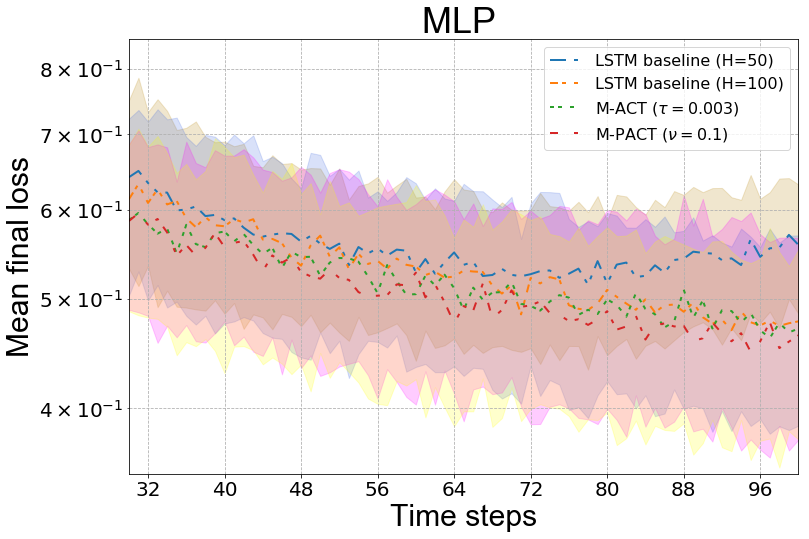

In [14]:
# some_experiments=[new_experiments[0],new_experiments[2],new_experiments[4]] #,  new_experiments[3]]
#                  # new_experiments[5], new_experiments[6]] #   new_experiments[4],
# some_experiments=[new_experiments[3],new_experiments[4] ]
                  
part = 2
if part == 1:
    min_step = 0
    max_step = 30
    y_lim=[0.45, 2.34] # step 0-30
    # y_lim=[0.35, 0.8]  # step 30-100
    log_scale  = True
elif part == 2:
    min_step = 30
    max_step = 100
    log_scale = True
    y_lim=[0.35, 0.85]
else:
    log_scale = True
    min_step = 100
    max_step = 200
    y_lim=[0.3, 0.8]

best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="mlp_1layer_all_" + str(min_step) + "_" + str(max_step),
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="MLP ",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)

In [ ]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [7]:
exp_idx = 0
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].meta_logger = logger
# backward compatibility...changed the names of the batch-handler for probabilistic model
# and Graves model
if new_experiments[exp_idx].args.learner == "act_sb" and new_experiments[exp_idx].args.version == "V3.2":
    new_experiments[exp_idx].batch_handler_class = "MPACTBatchHandler"
elif new_experiments[exp_idx].args.learner == "meta_act":
    new_experiments[exp_idx].batch_handler_class = "MACTBatchHandler"

epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} ".format(model.name))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_1layer_stats_50_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 50 test functions


Validating model act_sbV3.2_mlp_nu0.9 
 >>> Optimizing 1 MLP <<<
 >>> Optimizing 11 MLP <<<
 >>> Optimizing 21 MLP <<<
 >>> Optimizing 31 MLP <<<
 >>> Optimizing 41 MLP <<<


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 2.35   2.214  1.963  1.859  1.694  1.551  1.411  1.245  1.097  0.995
  0.887  0.814  0.756  0.726  0.684  0.657  0.63   0.6    0.629  0.618
  0.596  0.601  0.607  0.592  0.595  0.572  0.585  0.57   0.533  0.526
  0.546  0.582  0.553  0.539  0.551  0.517  0.527  0.529  0.54   0.56
  0.564  0.518  0.54   0.537  0.549  0.509  0.518  0.547  0.516  0.558
  0.504  0.502  0.546  0.543  0.535  0.513  0.526  0.534  0.522  0.513
  0.529  0.554  0.543  0.537  0.539  0.528  0.537  0.542  0.552  0.533
  0.546  0.566  0.532  0.55   0.546  0.565  0.552  0.541  0.553  0.542
  0.589  0.57   0.55   0.581  0.546  0.542  0.548  0.573  0.595  0.603
  0.568  0.575  0.562  0.601  0.576  0.597  0.58   0.585  0.587  0.575
  0.591  0.587  0.578  0.589  0.577  0.637  0.609  0.593  0.603  0.606
  0.624  0.583  0.611  0.619  0.59   0.596  0.61   0.623  0.628  0.603
  0.614  0.637  0.622  0.619  0.628  0.635  0.605  0.618  0.601  0.629
  0.634  0.613

End....


In [13]:
new_experiments[2].val_stats["qt_hist"][400].shape

(80,)

In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:
exp_idx = 1
max_steps = 60
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_50_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


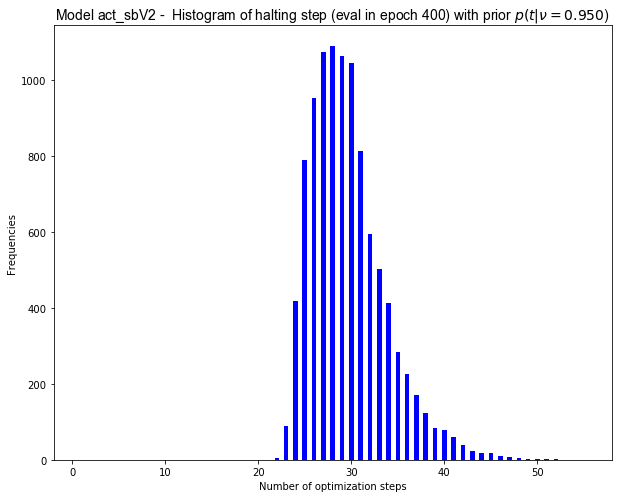

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

act_sbV3.2_mlp_nu0.9
('Sum p(t) ', 0.99999999999999989)
((86,), (86,), (86,))
INFO - Successfully saved fig logs/run_20170913_10_50_36_act_sbV3.2_125ep_nu0.9_lr1e04/trajectory_weights_test_t0_1.png


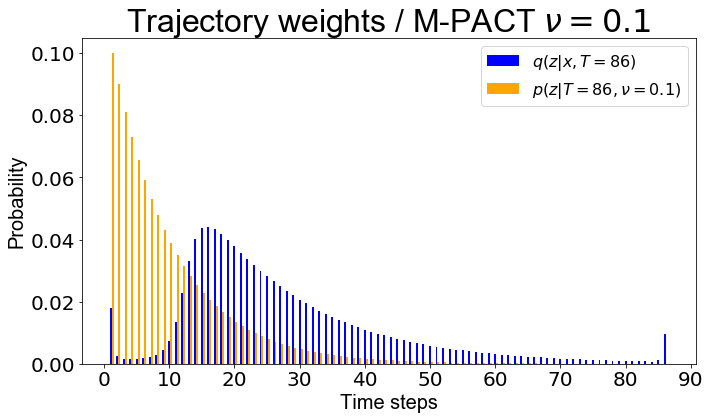

In [28]:
idx = 3

exper = new_experiments[idx]
print(exper.args.model)
if "act_sbV3.2" in exper.args.model:
    p_title=r"Trajectory weights / M-PACT $\nu={}$".format(1-exper.config.ptT_shape_param)
    hyper_param = str.replace(str(1-exper.config.ptT_shape_param), '.', '_')
else:
    p_title=r"Trajectory weights / M-ACT $\tau={}$".format(exper.config.tau)
    hyper_param = str.replace(str(exper.config.tau), '.', '_')


x_max = None

plot_actsb_qts(exper, data_set="eval", save=True, show=True, add_info=False, epoch=400, plot_prior=True,
              fig_name="trajectory_weights_test" + "_t{}".format(hyper_param), 
              huge=True,
              p_title=p_title,
              height=6, width=11, x_max=x_max)

20
[19 39 59]
INFO - Successfully saved fig logs/run_20171011_08_55_53_meta_actV1_70ep_tau0.003_lr1e04/mlp_1layer_mact_st_losses_t0_003.png


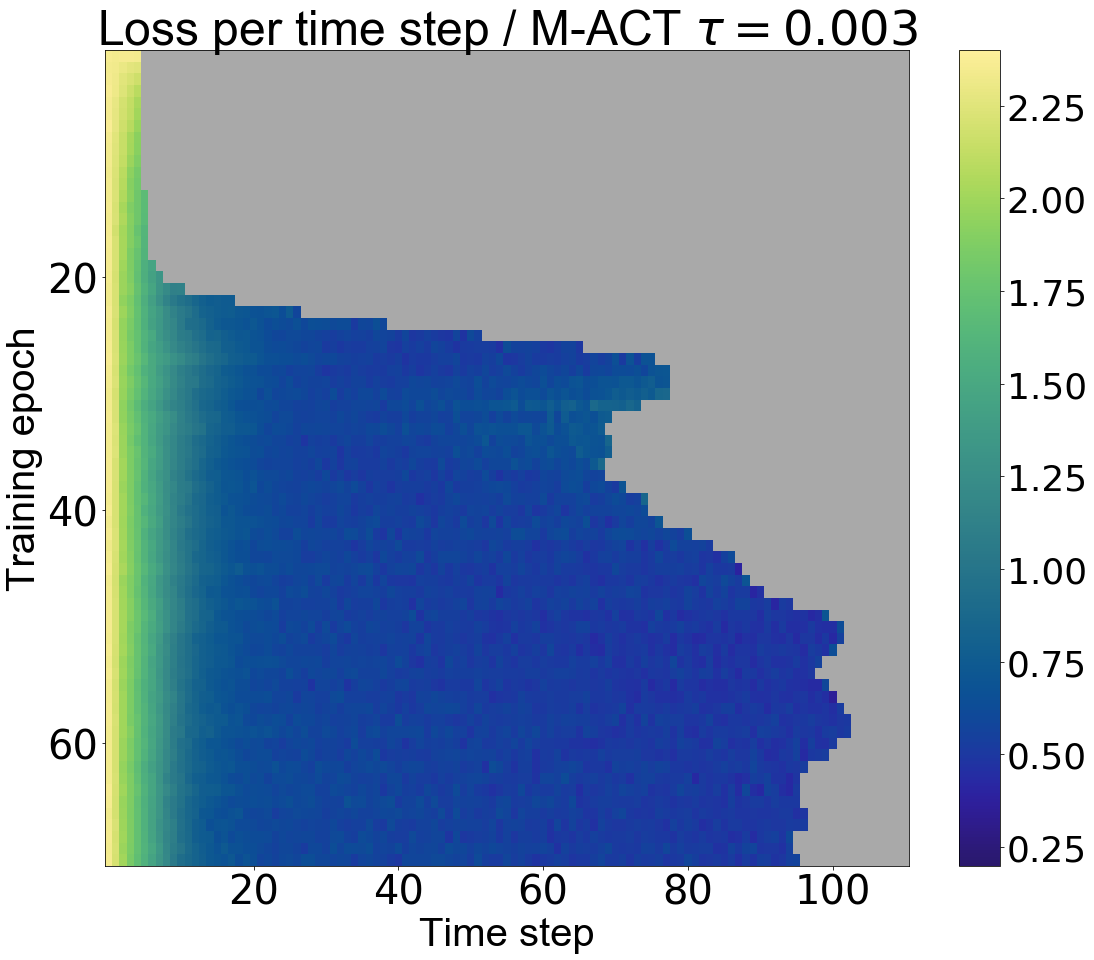

In [18]:
idx = 0

exper = experiments[idx]
if "act_sbV3.2" in exper.args.model:
    p_title="Loss per time step / M-PACT" + r" $\nu={}$".format(1-exper.config.ptT_shape_param)
    hyper_param = str.replace(str(1-exper.config.ptT_shape_param), '.', '_')
    fig_name="mlp_1layer_mpact_st_losses" + "_t{}".format(hyper_param)
else:
    p_title="Loss per time step / M-ACT" + r" $\tau={}$".format(exper.config.tau)
    hyper_param = str.replace(str(exper.config.tau), '.', '_')
    fig_name="mlp_1layer_mact_st_losses" + "_t{}".format(hyper_param)
    
max_epoch = None
max_time_step = 100

plot_image_map_losses(exper, fig_name=fig_name, do_save=True, do_show=True, 
                      max_epoch=max_epoch, max_time_step=max_time_step, 
                      fig_title=p_title, huge=True)

[ 20  40  60  80 100]
INFO - Successfully saved fig logs/run_20171011_08_55_53_meta_actV1_70ep_tau0.003_lr1e04/mlp_1layer_mact_train_halt_dist_t0_003.png


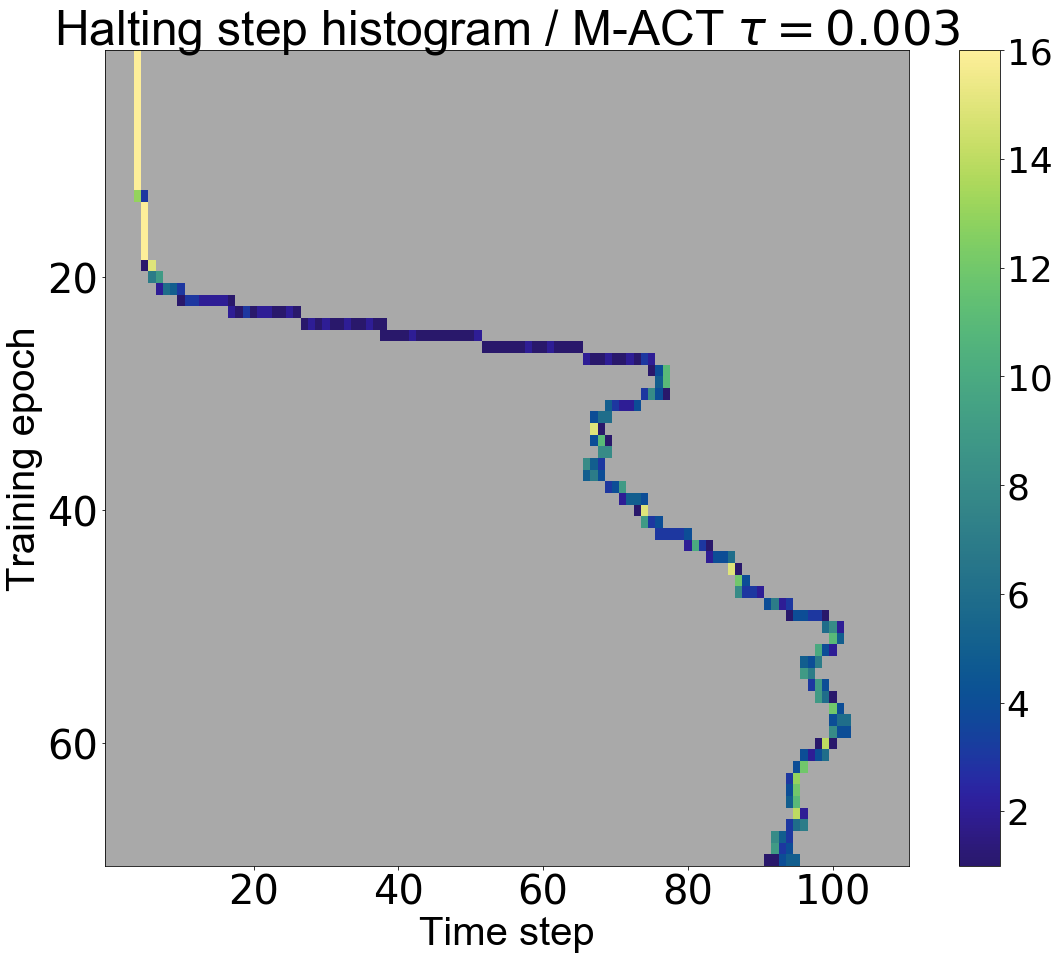

In [19]:
idx = 0

exper = experiments[idx]
if "act_sbV3.2" in exper.args.model:
    p_title="Halting step histogram / M-PACT" + r" $\nu={}$".format(1-exper.config.ptT_shape_param)
    hyper_param = str.replace(str(1-exper.config.ptT_shape_param), '.', '_')
    fig_name="mlp_1layer_mpact_train_halt_dist" + "_t{}".format(hyper_param)
else:
    p_title="Halting step histogram / M-ACT" + r" $\tau={}$".format(exper.config.tau)
    hyper_param = str.replace(str(exper.config.tau), '.', '_')
    fig_name="mlp_1layer_mact_train_halt_dist" + "_t{}".format(hyper_param)
    
max_epoch = None
max_time_step = 100

plot_image_map_data(exper, data_set="train",  do_save=True, do_show=True,
                        data="halting_step",  
                        max_epoch=None, max_time_step=max_time_step,
                        huge=True, 
                        plot_title=p_title,
                        fig_name=fig_name)

[ 20  40  60  80 100]


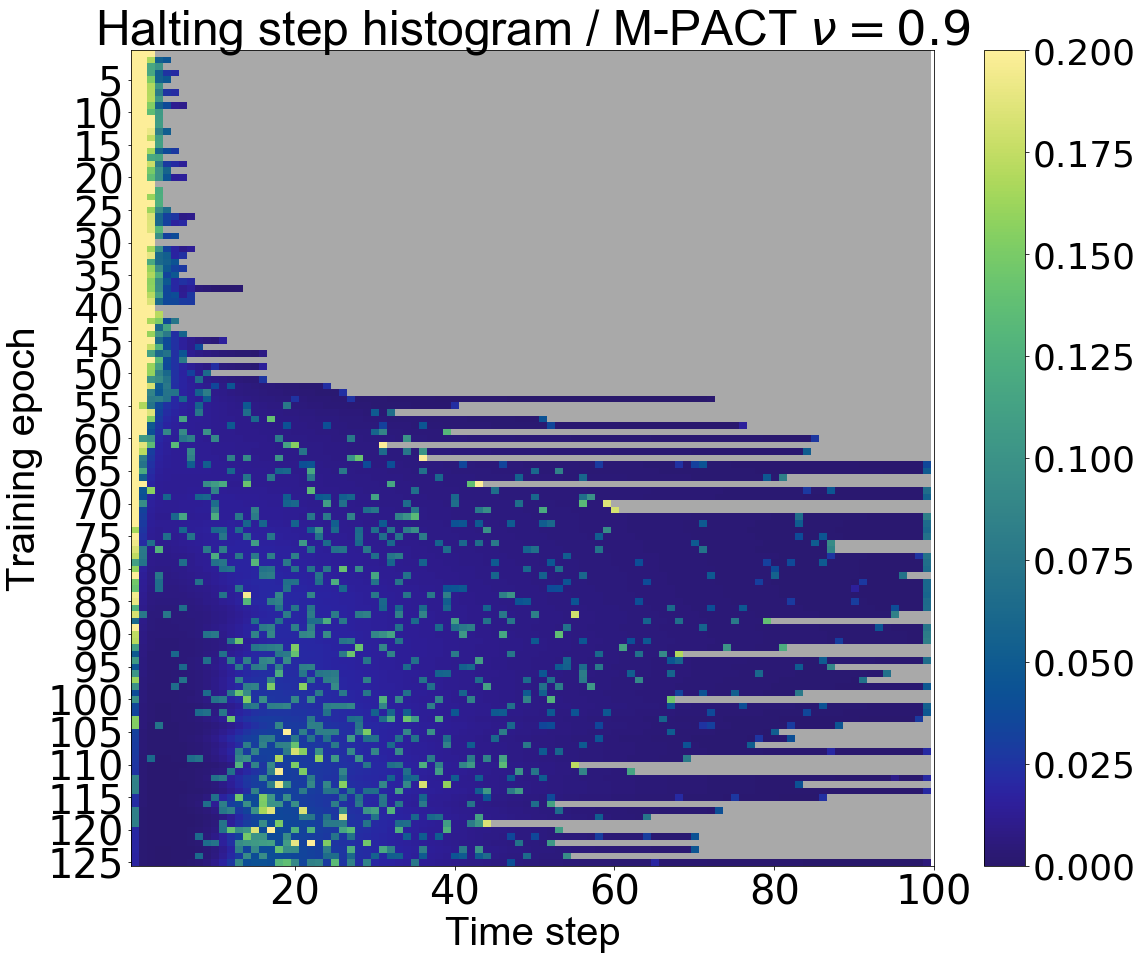

In [15]:
idx = 3

exper = experiments[idx]
if "act_sbV3.2" in exper.args.model:
    p_title="Halting step histogram / M-PACT" + r" $\nu={}$".format(exper.config.ptT_shape_param)
    hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
    fig_name="mlp_1layer_mpact_train_halt_dist" + "_t{}".format(hyper_param)
else:
    p_title="Halting step histogram / M-ACT" + r" $\tau={}$".format(exper.config.tau)
    hyper_param = str.replace(str(exper.config.tau), '.', '_')
    fig_name="mlp_1layer_mact_train_halt_dist" + "_t{}".format(hyper_param)
    
max_epoch = None

plot_image_map_data(exper, data_set="train",  do_save=False, do_show=True,
                        data="qt_value",  
                        max_epoch=None, max_time_step=100,
                        huge=True, 
                        plot_title=p_title,
                        fig_name=fig_name, scale=[0., 0.2])

INFO - Successfully saved fig figures/mlp_mact_mpact_mean_halt_all.png


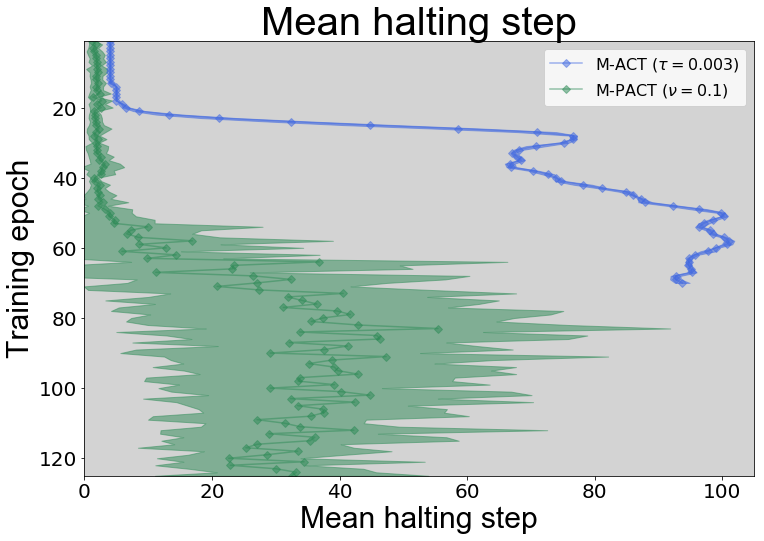

In [35]:
from utils.plots import plot_halting_step_stats

    
plot_halting_step_stats(experiments, do_show=True, do_save=True, last_epoch=None, xlim=[0,105], model_in_label=True,
                        fig_title="Mean halting step", fig_name="mlp_mact_mpact_mean_halt_all")

In [9]:
# generate new validation and test set for mixed MLPs
mixed_mlp = False
test_funcs = []
num_of_funcs = 100
binary_switch = 0
for _ in np.arange(num_of_funcs):
    if mixed_mlp:
        if binary_switch == 0:
            test_funcs.append(MLP(default_mlp_architecture))
            binary_switch = 1
        else:
            test_funcs.append(MLP(two_layer_mlp_architecture))
            binary_switch = 0
    else:
        test_funcs.append(MLP(default_mlp_architecture))

if mixed_mlp:
    file_prefix = "data/test_mixed_mlp_"
else:
    file_prefix = "data/test_mlp_"

    
with open(file_prefix + str(num_of_funcs) + ".dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready {}".format(file_prefix))

Ready


In [20]:
experiments[4].generate_figures()

INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/loss_train_act_sbV3.2_125ep_nu0.9kls0.03.png
(100, 125)
INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/loss_optimizer_train_act_sbV3.2_125ep_nu0.9kls0.03.png
(101, 10)
INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/train_step_loss_map_act_sbV3.2_125ep_nu0.9kls0.03.png
INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/T_dist_train.png
INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/gradient_statistics.png
INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/train_step_map_qts_act_sbV3.2_125ep_nu0.9kls0.03.png
INFO - Successfully saved fig logs/run_20171011_15_59_20_act_sbV3.2_125ep_nu0.9kls0.03_lr1e04/train_step_map_halting_act_sbV3.2_125ep_nu0.9kls0.03.png
INFO - Successfu

In [53]:
new_exp = Experiment(new_experiments[6].args, new_experiments[6].config, set_seed=True)
new_exp.batch_handler_class = new_experiments[6].batch_handler_class
new_exp.output_dir = new_experiments[6].output_dir
new_exp.meta_logger = logger
new_exp.validation_handler_class = new_experiments[6].validation_handler_class
new_exp.training_horizon = new_experiments[6].config.T

new_exp.val_stats["step_losses"][400] = new_experiments[6].val_stats["step_losses"][400]
new_exp.val_stats["opt_step_hist"][400] = new_experiments[6].val_stats["opt_step_hist"][400]
new_exp.val_stats["halting_step"][400] = new_experiments[6].val_stats["halting_step"][400]
new_exp.val_stats["qt_hist"][400] = new_experiments[6].val_stats["qt_hist"][400]
new_exp.val_stats["step_acc"][400] = new_experiments[6].val_stats["step_acc"][400]
new_exp.save("exp_eval_stats_200_"+str(200) + "steps.dll")

INFO - Epoch: 0 - Saving experimental details to logs/run_20170913_10_50_36_act_sbV3.2_125ep_nu0.9_lr1e04/exp_eval_stats_200_200steps.dll


In [79]:
def transform_halting_steps_to_opt_steps(halt_steps, last_epoch=None):
    r = []
    for i, steps in enumerate(halt_steps):
        max_idx = np.max(steps.nonzero())
        # skip first 0-step
        l = []
        for j, counter in enumerate(steps[1:max_idx+1]):
            if counter != 0:
                l.extend([j+1] * counter)
        r.append(l)
    return r
        
schedule = np.vstack(experiments[1].epoch_stats["halting_step"].values())

schedule = transform_halting_steps_to_opt_steps(schedule)
print(len(schedule))
with open("data/curriculum.dll", 'wb') as f:
     dill.dump(schedule, f)
print("Ready")

125
Ready


In [ ]:
total_ops = 0

idx = 4
exper = experiments[idx]
new_exper = new_experiments[idx]
print(exper.args.model)
if "act_sbV3.2" in exper.args.model or "meta_actV1" in exper.args.model:
    total_ops = compute_total_steps(exper, epoch_range=None)
step_losses = get_evaluation_step_loss(new_exper, steps=[1, 10, 50, 100])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses, precision=2))

In [15]:
total_ops = 0

idx = 0
new_exper = new_experiments[idx]
print(new_exper.args.model)

step_losses = get_evaluation_step_loss(new_exper, steps=[1, 10, 50, 91, 100])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses, precision=2))

meta_actV1_mlp_tau0.003
Total steps 0
Step losses
[ 2.21  0.95  0.52  0.47  0.47  0.41]


In [12]:
for e in new_experiments:
    if "act_sbV3.2" in e.args.model or "meta_actV1" in e.args.model: 
        print(e.args.model)
        mean, std, median, _ , a_range = e.get_step_dist_statistics(with_range=True)
        print("[{}, {}] & {:.2f} & {:.2f} & {} ".format(a_range[0], a_range[1], round(mean,2), round(std,2), median))

act_sbV3.2_mlp_nu0.9
[119, 126] & 122.56 & 1.55 & 123 
act_sbV3.2_mlp_nu0.9
[117, 122] & 119.18 & 1.03 & 119 


In [10]:
for e in new_experiments:
    print("{} {:.2f}".format(e.args.model, e.val_stats["step_acc"][400]))

act_sbV3.2_mlp_nu0.9 75.39


In [7]:
from utils.common import compute_mean_training_horizon
print(compute_mean_training_horizon(experiments[1]))

18.5235
